In [1]:
from fastai.vision import * #import from vision to use the classification interpreter
from pathlib import Path
import pdb
import seaborn as sns
from scipy.signal import resample
from sklearn.decomposition import PCA
path = Path("earthquake")
from timeseries import TimeSeriesItem, TimeSeriesList, UCRArchive

In [ ]:
trainDF = pd.read_csv(path/"train.csv",dtype={"acoustic_data": np.float32, "time_to_failure": np.float32})

In [2]:
trainDF = pd.read_feather(path/"eq.feather")

C:\Users\lordn\Anaconda3\envs\fastai\lib\site-packages\pandas\io\feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


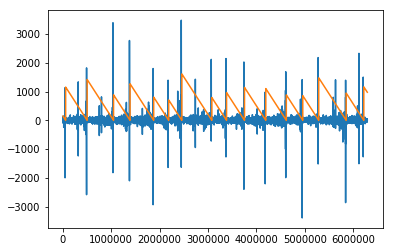

In [5]:
sample_freq = 100
plt.plot(trainDF.acoustic_data.values[::sample_freq])
plt.plot(trainDF.time_to_failure.values[::sample_freq]*100)

In [ ]:
x = pd.DataFrame(np.random.rand(10,20))

In [ ]:
r = x.rolling(2,axis=1)
r = r.std()

In [ ]:
r.dropna(axis=1)
#r.dropna(axis=1)
#

In [ ]:
def get_rolling_stats(z):
    x_raw = pd.DataFrame(z)
    features = []
    for windows in [10,100]:
        x_roll_std = x_raw.rolling(windows,axis=1).std().dropna(axis=1).values
        x_roll_mean = x_raw.rolling(windows,axis=1).mean().dropna(axis=1).values

        features += [x_roll_std.mean(axis=1), x_roll_std.std(axis=1), x_roll_std.max(axis=1), x_roll_std.min(axis=1),
                     np.quantile(x_roll_std,0.01,axis=1), np.quantile(x_roll_std,0.05,axis=1), np.quantile(x_roll_std,0.95,axis=1),
                     np.quantile(x_roll_std,0.99,axis=1), np.mean(np.diff(x_roll_std),axis=1),
                     np.abs(x_roll_std).max(axis=1)]
        features += [x_roll_mean.mean(axis=1),x_roll_mean.std(axis=1),x_roll_mean.max(axis=1),x_roll_mean.min(axis=1),
                    np.quantile(x_roll_mean,0.01,axis=1),np.quantile(x_roll_mean,0.05,axis=1),np.quantile(x_roll_mean,0.95,axis=1),
                    np.quantile(x_roll_mean,0.99,axis=1),np.mean(np.diff(x_roll_mean),axis=1),
                    np.abs(x_roll_mean).max(axis=1)]
        
    return features

In [3]:
def extract_features(z):
    features = [z.mean(axis=1),
                *np.quantile(z,[.01,.05,.95,.99],axis=1),
                z.min(axis=1),
                z.max(axis=1),
                z.std(axis=1)]
    
    return np.stack(features,axis=1)

In [4]:
extract_features(np.random.rand(10,1000)).shape

(10, 8)

In [5]:
def create_X(x, last_index=None, n_steps=150, step_length=1000):
    if last_index == None:
        last_index=len(x)
       
    assert last_index - n_steps * step_length >= 0

    # Reshaping and approximate standardization with mean 5 and std 3.
    x = x[(last_index - n_steps * step_length):last_index]
    temp = (x.reshape(n_steps, -1) - 5 ) / 3

    # Extracts features of sequences of full length 1000, of the last 100 values and finally also 
    # of the last 10 observations. 
    return np.c_[extract_features(temp),
                 extract_features(temp[:, -step_length // 10:]),
                 extract_features(temp[:, -step_length // 100:])]

In [6]:
class RandPosDS(torch.utils.data.Dataset):
    def __init__(self,data,min_index=0,max_index=0,n_steps=150,step_length=1000):
        self.data, self.n_steps, self.step_length = data, n_steps, step_length
        self.min_index = min_index
        self.max_index = max_index if max_index > 0 else len(data) - 1
        
    def __len__(self): return 2000
    
    def __getitem__(self,idx):
        end = np.random.randint(self.min_index + self.n_steps * self.step_length,self.max_index)
        return (create_X(self.data[:,0],last_index=end,n_steps=self.n_steps,step_length=self.step_length).astype(np.float32),
                self.data[end,1])

In [76]:
class RandPosDSWithTest(torch.utils.data.Dataset):
    def __init__(self,data,testX,min_index=0,max_index=0,n_steps=150,step_length=1000):
        self.data, self.testX, self.n_steps, self.step_length = data, testX, n_steps, step_length
        self.min_index = min_index
        self.max_index = max_index if max_index > 0 else len(data) - 1
        
    def __len__(self): return 2000 + len(self.testX)
    
    def __getitem__(self,idx):
        if idx < 2000:
            end = np.random.randint(self.min_index + self.n_steps * self.step_length,self.max_index)
            x = create_X(self.data[:,0],last_index=end,n_steps=self.n_steps,step_length=self.step_length).astype(np.float32)
            return x,x[:,0]
        else:
            return self.testX[idx-2000],self.testX[idx-2000][:,0]

In [43]:
class RandPosPregenDS(torch.utils.data.Dataset):
    def __init__(self,data,length=2000,min_index=0,max_index=0,n_steps=150,step_length=1000):
        self.data, self.n_steps, self.step_length, self.length = data, n_steps, step_length, length
        self.min_index = min_index
        self.max_index = max_index if max_index > 0 else len(data) - 1
        self.out = []
        for i in range(self.length):
            end = np.random.randint(self.min_index + self.n_steps * self.step_length,self.max_index)
            self.out.append((create_X(self.data[:,0],last_index=end,n_steps=self.n_steps,step_length=self.step_length).astype(np.float32),
                             self.data[end,1]))
        
    def __len__(self): return self.length
    
    def __getitem__(self,idx):
        return self.out[idx]

In [25]:
second_earthquake = 50085877
trainDS = RandPosPregenDS(trainDF.values)
valDS = RandPosPregenDS(trainDF.values,max_index = second_earthquake)
trainDS.items = [1,2,3]
valDS.items = [1,2,3]
data = DataBunch.create(trainDS,valDS,num_workers=0)

In [34]:
testX = []
testL = []
for f in progress_bar(list((path/"test").glob("*.csv"))):
    seg_id = f.name[:-4]
    testL.append(seg_id)
    df = pd.read_csv(f,dtype={"acoustic_data": np.float32})
    x = df.acoustic_data.values
    testX.append(create_X(x))
    
testX = np.stack(testX).astype(np.float32)

In [83]:
dataAE = DataBunch.create(RandPosDSWithTest(trainDF.values,testX),RandPosDSWithTest(trainDF.values,testX),num_workers=0)
dataAE.train_ds.items = [1,2,3]
dataAE.valid_ds.items = [1,2,3]

In [35]:
testX.shape

(2624, 150, 24)

In [ ]:
dataTest = (TimeSeriesList.from_numpy(testX)
                          .no_split()
                          .label_from_list(testL)
                          .databunch(bs=32,num_workers=0))

In [26]:
n_features = create_X(trainDF.acoustic_data.values[0:150000]).shape[1]

In [10]:
class BasicLSTM(torch.nn.Module):
    def __init__(self,n_features):
        super().__init__()
        self.rnn = torch.nn.LSTM(n_features,100,2,batch_first=True,bidirectional=True)
        self.out = create_head_1d(200,1,lin_ftrs=[200,300])
        
    def forward(self,ts):
        output,(h_n,c_n) = self.rnn(ts)
        x = torch.cat([h_n[-1],h_n[-2]],dim=-1)
        output = self.out(x).squeeze(-1)
        return torch.sigmoid(output) * 20.0

In [27]:
class EQClassifier(torch.nn.Module):
    def __init__(self,n_features,maxY=20.0):
        super().__init__()
        self.maxY =  maxY
        #self.conv = SidekickResnet(1,3,3,6,12,n_features=n_features,start_nf=16,start_nf_hero=16)
        self.conv = HeroResnet(3,3,2,start_nf=48,n_features=n_features)
        self.out = create_head_1d(self.conv.nf,1)
        
    def forward(self,ts):
        ts, _ = self.conv(ts.transpose(1,2))
        return torch.sigmoid(self.out(ts.squeeze(-1)).squeeze(-1)) * self.maxY

In [ ]:
class SidekickClassifier(torch.nn.Module):
    def __init__(self,n_features,maxY=20.0):
        super().__init__()
        self.maxY =  maxY
        self.conv = SidekickResnet(1,3,3,2,4,n_features=n_features,start_nf=48,start_nf_hero=48)
        
    def forward(self,ts):
        out = self.conv(ts.transpose(1,2))
        return torch.sigmoid(out.squeeze(-1)) * self.maxY    

In [28]:
def mean_absolute_error(pred:Tensor, targ:Tensor)->Rank0Tensor:
    return torch.abs(pred-targ).mean()

In [78]:
#model=BasicLSTM(n_features)
model = EQClassifier(n_features)
learn = Learner(data,model,loss_func=F.mse_loss,metrics=[mean_absolute_error])

In [30]:
learn.model(next(iter(data.train_dl))[0]).size()

torch.Size([64])

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(10,1e-4,wd=0.2)

epoch,train_loss,valid_loss,mean_absolute_error
1,4.604849,21.148186,3.692570
2,4.533485,21.087204,3.654886
3,4.482064,18.479216,3.458671
4,4.364244,22.068735,3.744453
5,4.112816,21.130686,3.697041
6,3.840531,17.809851,3.442258
7,3.557853,21.409081,3.730673
8,3.334109,20.701809,3.675869
9,3.168342,25.494320,3.995512
10,3.065139,19.924585,3.617301


In [ ]:
learnTest = Learner(dataTest,model,loss_func=F.mse_loss)

In [ ]:
preds,lbl = learnTest.get_preds(DatasetType.Train)

In [ ]:
lbl = [dataTest.y.classes[l.item()] for l in lbl]

In [ ]:
preds = preds.tolist()

In [ ]:
testOutDF = pd.DataFrame({"seg_id": lbl,"time_to_failure":preds})
testOutDF.head()

In [ ]:
testOutDF.to_csv(path/"out.csv",index=False)

In [71]:
class EQAE(torch.nn.Module):
    def __init__(self,n_features,seqLen,latentDim=24):
        super().__init__()
        #latentDim = max(seqLen // 8,8)
        self.conv = HeroResnet(3,3,2,start_nf=48,n_features=n_features)
        self.mean = torch.nn.Linear(self.conv.nf,latentDim)
        self.logvar = torch.nn.Linear(self.conv.nf,latentDim)
        

        layers = []
        for a,b in [(latentDim,100),(100,200),(200,300)]:
            layers += bn_drop_lin(a,b,actn=torch.nn.ReLU())
        self.lin = torch.nn.Sequential(*layers)
        self.out = torch.nn.Linear(300,seqLen)

    def forward(self,ts):
        seqLen = ts.shape[1]
        ts, _ = self.conv(ts.transpose(1,2))
        ts = ts.squeeze(-1)
        mean, logvar = self.mean(ts), self.logvar(ts)
        #mean = self.mean(ts)
        
        ls = mean
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            ls = eps.mul(std).add_(mean)
        #return self.out(self.lin(ls))          
        return self.out(self.lin(ls)), mean, logvar

In [68]:
class VAELoss(torch.nn.Module):
    def __init__(self,beta=1.0):
        super().__init__()
        self.beta = beta
    def forward(self,p,target):
        pred,mean,logvar = p
        self.mse = torch.nn.functional.mse_loss(pred,target,reduction="sum")
        self.kld = self.beta * -0.5 * torch.sum(1+logvar-mean.pow(2)-logvar.exp())
        return self.mse + self.kld
class PrintLosses(LearnerCallback):
    _order=-20
    def __init__(self,learn):
        super().__init__(learn)
    def on_train_begin(self, **kwargs):
        self.learn.recorder.add_metric_names(["mse","kld"])
    def on_epoch_end(self, **kwargs):
        self.learn.recorder.add_metrics([self.learn.loss_func.mse,self.learn.loss_func.kld])

In [84]:
learnAE = Learner(dataAE,EQAE(n_features,150),loss_func=VAELoss())

In [80]:
learnAE.model(dataAE.one_batch()[0].cuda())[0].size()

torch.Size([64, 150])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


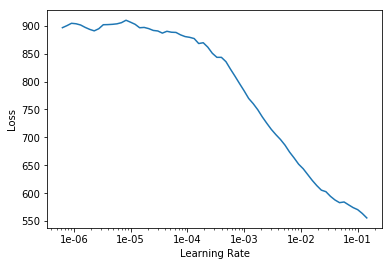

In [81]:
learnAE.lr_find()
learnAE.recorder.plot()

In [85]:
learnAE.fit_one_cycle(10,1e-2,wd=0.2)

epoch,train_loss,valid_loss
1,265.677856,257.274872
2,200.775192,220.790558
3,189.357407,179.682053
4,173.898285,132.565781
5,169.363464,171.980392
6,162.615631,160.133102
7,163.520691,154.726791
8,157.200958,143.721008
9,158.037354,146.808548
10,160.939240,148.426071


In [86]:
learnAE.show_results(DatasetType.Train,channels=[0])

AttributeError: 'RandPosDSWithTest' object has no attribute 'x'

In [13]:
def conv1d(ni:int, nf:int, ks:int=3, stride:int=1, padding:int=None, bias=False, init:LayerFunc=nn.init.kaiming_normal_) -> nn.Conv1d:
    "Create and initialize `nn.Conv1d` layer. `padding` defaults to `ks//2`."
    if padding is None: padding = ks//2
    return init_default(nn.Conv1d(ni, nf, kernel_size=ks, stride=stride, padding=padding, bias=bias), init)

def _bn1d(ni, init_zero=False):
    "Batchnorm layer with 0 initialization"
    m = nn.BatchNorm1d(ni)
    m.weight.data.fill_(0 if init_zero else 1)
    m.bias.data.zero_()
    return m

def bn_relu_conv1d(ni, nf, ks, stride, init_zero=False):
    bn_initzero = _bn1d(ni, init_zero=init_zero)
    return nn.Sequential(bn_initzero, nn.ReLU(inplace=True), conv1d(ni, nf, ks, stride))

class ResBlock(torch.nn.Module):
    def __init__(self, ni, nf, stride, drop_p=0.0):
        super().__init__()
        self.bn = nn.BatchNorm1d(ni)
        self.conv1 = conv1d(ni, nf, 3, stride)
        self.conv2 = bn_relu_conv1d(nf, nf, 3, 1)
        self.drop = nn.Dropout(drop_p, inplace=True) if drop_p else None
        self.shortcut = conv1d(ni, nf, 1, stride) if ni != nf or stride > 1 else noop

    def forward(self, x):
        x2 = F.relu(self.bn(x), inplace=True)
        r = self.shortcut(x2)
        x = self.conv1(x2)
        if self.drop: x = self.drop(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)

def _make_group(N, ni, nf, block, stride, drop_p):
    return [block(ni if i == 0 else nf, nf, stride if i == 0 else 1, drop_p) for i in range(N)]

class WideResNet1d(nn.Module):
    "Wide ResNet with `num_groups` and a width of `k`."
    def __init__(self, num_groups:int, N:int, k:int=1, drop_p:float=0.0, start_nf:int=16,maxY=20.0):
        super().__init__()
        self.maxY = maxY
        n_channels = [start_nf]
        for i in range(num_groups): n_channels.append(start_nf*(2**i)*k)
        
        
        layers = [conv1d(1, n_channels[0], 3, 1)]  # conv1
        self.split_groups = [layers[-1]] 
        
        for i in range(num_groups):
            layers += _make_group(N, n_channels[i], n_channels[i+1], ResBlock, (1 if i==0 else 2), drop_p)
            self.split_groups.append(layers[-N])
            
        layers += [nn.BatchNorm1d(n_channels[-1]), nn.ReLU(inplace=True), nn.AdaptiveAvgPool1d(1),
                   Flatten()]
        #self.split_groups.append(layers[-1])
        self.nf = n_channels[-1]
        self.features = nn.Sequential(*layers)

    def forward(self, x):
        #x = x.unsqueeze(1)
        return self.features(x)

In [14]:
def create_head_1d(nf:int, nc:int, lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5, bn_final:bool=False):
    "Model head that takes `nf` features, runs through `lin_ftrs`, and about `nc` classes."
    lin_ftrs = [nf, 512, nc] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    ps = listify(ps)
    if len(ps)==1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    layers = []
    for ni,no,p,actn in zip(lin_ftrs[:-1],lin_ftrs[1:],ps,actns):
        layers += bn_drop_lin(ni,no,True,p,actn)
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    return nn.Sequential(*layers)

class HeroResnet(nn.Module):
    def __init__(self, num_groups:int, N:int, k:int=1, n_features:int=1, drop_p:float=0.0, start_nf:int=16):
        super().__init__()
        n_channels = [start_nf]
        for i in range(num_groups): n_channels.append(start_nf*(2**i)*k)

        self.layer0 = conv1d(n_features,n_channels[0],3,1)
        self.split_groups = [self.layer0]
        
        groups = [nn.Sequential(*_make_group(N,n_channels[i],n_channels[i+1],ResBlock,(1 if i==0 else 2),drop_p)) for i in range(num_groups)]
        
        self.groups = nn.ModuleList(groups)
        for g in self.groups: self.split_groups.append(g)
        
        self.out = nn.Sequential(nn.BatchNorm1d(n_channels[-1]),
                                 nn.ReLU(inplace=True),
                                 nn.AdaptiveAvgPool1d(1))               
        
        self.split_groups.append(self.out)
        self.nf = n_channels[-1]
        
    def forward(self, x):
        actvns = [self.layer0(x)]
        
        for l in self.groups:
            actvns.append(l(actvns[-1]))
            
        return self.out(actvns[-1]), actvns
    
class SidekickResnet(nn.Module):
    def __init__(self, num_classes:int, num_groups:int, N:int, k:int=1, hero_k:int=1,n_features:int=1, drop_p:float=0.0, start_nf:int=16, start_nf_hero:int=16):
        super().__init__()
        n_channels = [start_nf]
        
        self.hero = HeroResnet(num_groups,N,hero_k,drop_p=drop_p,start_nf=start_nf_hero,n_features=n_features)
        
        for i in range(num_groups): n_channels.append(start_nf*(2**i)*k)
            
        n_channels_hero = [start_nf_hero]
        for i in range(num_groups): n_channels_hero.append(start_nf_hero*(2**i)*hero_k)   
            
        self.layer0 = conv1d(n_features,n_channels[0],3,1)
        
        groups = [nn.Sequential(*_make_group(N,n_channels[i]+n_channels_hero[i],n_channels[i+1],ResBlock,(1 if i==0 else 2),drop_p)) for i in range(num_groups)]

        
        self.groups = nn.ModuleList(groups)
        
        self.avg = nn.Sequential(nn.BatchNorm1d(n_channels[-1]),
                                 nn.ReLU(inplace=True),
                                 nn.AdaptiveAvgPool1d(1))
        
        self.out = create_head_1d(n_channels[-1]+n_channels_hero[-1],num_classes)
        
    def forward(self,ts):
        pt, actvns = self.hero(ts)
        
        x = self.layer0(ts)
        for l,a in zip(self.groups,actvns):
            x = l(torch.cat([x,a],dim=1))
            
        x = torch.cat([self.avg(x),pt],dim=1).squeeze(-1)
        
        return self.out(x)        